In [56]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models'])
import models
from utils import test_accuracy, train_epoch, show_weights, model_prune, print_dims, get_kd_targets, get_weight_penalty
import copy
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
plt.rcParams['text.color'] = 'white'

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_full = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
use_cuda = torch.cuda.is_available()

## LeNet 300-100

### 1. Train Model

In [57]:
model = models.LeNet_300_100()
#print_dims(model)

num_epochs = 100
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)
graph_title='original_model/'

model.cuda()
for epoch in range(num_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    
    test_acc = test_accuracy(test_loader, model, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model, get_loss=True)
    weight_penalty = get_weight_penalty(model)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
    writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
    writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
    for name, param in model.named_parameters():
        writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        
    #print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], test_acc[0]))
    
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))

### 2. Re-train Model

Epoch: 1. Train CE Loss: 1.509, Train Accuracy: 98.578, Test CE Loss: 1.516, Test Accuracy: 97.050, Model L2: 25.550
Epoch: 2. Train CE Loss: 1.538, Train Accuracy: 97.863, Test CE Loss: 1.540, Test Accuracy: 96.840, Model L2: 19.449
Epoch: 3. Train CE Loss: 1.543, Train Accuracy: 97.913, Test CE Loss: 1.546, Test Accuracy: 97.040, Model L2: 17.958
Epoch: 4. Train CE Loss: 1.541, Train Accuracy: 97.780, Test CE Loss: 1.543, Test Accuracy: 97.000, Model L2: 17.438
Epoch: 5. Train CE Loss: 1.542, Train Accuracy: 97.827, Test CE Loss: 1.543, Test Accuracy: 97.010, Model L2: 17.179
Epoch: 6. Train CE Loss: 1.540, Train Accuracy: 97.775, Test CE Loss: 1.541, Test Accuracy: 96.990, Model L2: 17.068
Epoch: 7. Train CE Loss: 1.541, Train Accuracy: 97.975, Test CE Loss: 1.542, Test Accuracy: 97.120, Model L2: 16.917
Epoch: 8. Train CE Loss: 1.540, Train Accuracy: 97.858, Test CE Loss: 1.542, Test Accuracy: 97.040, Model L2: 16.885
Epoch: 9. Train CE Loss: 1.539, Train Accuracy: 97.957, Test CE 

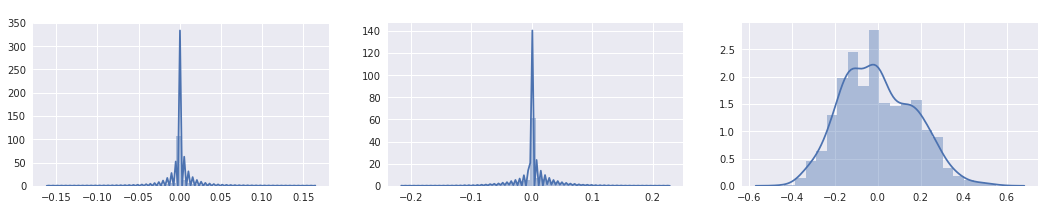

In [58]:
#Get KD Targets   
model_name = 'LeNet_300_100'

model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs)).cuda()
temp = 3
train_kd_dataset = get_kd_targets(train_dataset, model, temp)
train_kd_loader = torch.utils.data.DataLoader(dataset=train_kd_dataset, batch_size=batch_size, shuffle=True)

#Load model
model_kd = models.LeNet_300_100().cuda()
model_kd.load_state_dict(model.state_dict())

#Set up Optimisers and loss
criterion_kd = nn.MSELoss()
learning_rate_kd = 0.0005
wd_kd = 0.0001
optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

graph_title = "compressed_model_T={}/".format(temp)

retraining_epochs=100
for epoch in range(retraining_epochs):
    model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
    model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
    model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
    test_acc = test_accuracy(test_loader, model_kd, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_kd, get_loss=True)
    weight_penalty = get_weight_penalty(model_kd)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
    writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
    writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
    for name, param in model.named_parameters():
        writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    
    print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
show_weights(model_kd)

In [ ]:
torch.save(model_kd, model_dir + 'mnist_{}_kd_{}.m'.format(model_kd.name, retraining_epochs))

### 3. Prune Model

In [60]:
model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_100.m')
model_c = models.LeNet_300_100().cuda()
pruner = model_prune(model_kd.state_dict())
deviation_list = [x/10.0 for x in range(0,21)]
percentile_list = range(0,101,5)

In [29]:
dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
for lim in deviation_list:
    model_c.load_state_dict(pruner.deviation_prune(lim))
    test_acc = test_accuracy(test_loader, model_c, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_c, get_loss=True)
    weight_penalty = get_weight_penalty(model_c)
    
    dev_res['train ce'].append(train_acc[1])
    dev_res['test ce'].append(test_acc[1])
    dev_res['train acc'].append(train_acc[0])
    dev_res['test acc'].append(test_acc[0])
    dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
    dev_res['L2'].append(weight_penalty)
    
    print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
          .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))

Train CE Loss: 1.522, Train Accuracy: 98.568, Test CE Loss: 1.526, Test Accuracy: 97.790, Model L2: 17.448, Parameters Pruned: 0/266610 - 0.000%
Train CE Loss: 1.522, Train Accuracy: 98.553, Test CE Loss: 1.526, Test Accuracy: 97.740, Model L2: 17.449, Parameters Pruned: 148302/266610 - 55.625%
Train CE Loss: 1.522, Train Accuracy: 98.532, Test CE Loss: 1.527, Test Accuracy: 97.760, Model L2: 17.450, Parameters Pruned: 174338/266610 - 65.391%
Train CE Loss: 1.524, Train Accuracy: 98.515, Test CE Loss: 1.528, Test Accuracy: 97.730, Model L2: 17.425, Parameters Pruned: 184748/266610 - 69.295%
Train CE Loss: 1.527, Train Accuracy: 98.463, Test CE Loss: 1.531, Test Accuracy: 97.680, Model L2: 17.382, Parameters Pruned: 193440/266610 - 72.555%
Train CE Loss: 1.535, Train Accuracy: 98.282, Test CE Loss: 1.538, Test Accuracy: 97.530, Model L2: 17.299, Parameters Pruned: 200837/266610 - 75.330%
Train CE Loss: 1.545, Train Accuracy: 98.057, Test CE Loss: 1.547, Test Accuracy: 97.310, Model L2: 

In [28]:
perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}

graph_title = 

for lim in percentile_list:
    model_c.load_state_dict(pruner.percentile_prune(lim))
    
    test_acc = test_accuracy(test_loader, model_c, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_c, get_loss=True)
    weight_penalty = get_weight_penalty(model_kd)
    perc_res['train ce'].append(train_acc[1])
    perc_res['test ce'].append(test_acc[1])
    perc_res['train acc'].append(train_acc[0])
    perc_res['test acc'].append(test_acc[0])
    perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
    perc_res['L2'].append(weight_penalty)
    
    print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
          .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))

Train CE Loss: 1.522, Train Accuracy: 98.568, Test CE Loss: 1.526, Test Accuracy: 97.790, Model L2: 17.448, Parameters Pruned: 0/266610 - 0.000%
Train CE Loss: 1.522, Train Accuracy: 98.572, Test CE Loss: 1.526, Test Accuracy: 97.770, Model L2: 17.448, Parameters Pruned: 13310/266610 - 4.992%
Train CE Loss: 1.522, Train Accuracy: 98.552, Test CE Loss: 1.526, Test Accuracy: 97.740, Model L2: 17.448, Parameters Pruned: 26620/266610 - 9.985%
Train CE Loss: 1.522, Train Accuracy: 98.550, Test CE Loss: 1.527, Test Accuracy: 97.740, Model L2: 17.448, Parameters Pruned: 39930/266610 - 14.977%
Train CE Loss: 1.523, Train Accuracy: 98.550, Test CE Loss: 1.527, Test Accuracy: 97.710, Model L2: 17.448, Parameters Pruned: 53240/266610 - 19.969%
Train CE Loss: 1.524, Train Accuracy: 98.518, Test CE Loss: 1.529, Test Accuracy: 97.730, Model L2: 17.448, Parameters Pruned: 66550/266610 - 24.962%
Train CE Loss: 1.526, Train Accuracy: 98.512, Test CE Loss: 1.531, Test Accuracy: 97.680, Model L2: 17.448,